In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Загрузка данных

In [181]:
data_dir = './data/raw/participants/'
test_news = pd.read_csv(data_dir + 'train_news.csv')
train_news = pd.read_csv(data_dir + "train_news.csv")
train_candles = pd.read_csv(data_dir + 'train_candles.csv')

### Обработка данных

##### Удаление дубликатов

In [182]:
# Найдем дубликаты по паре (ticker, begin)
duplicates = train_candles[train_candles.duplicated(subset=['ticker', 'begin'], keep=False)]

total_diff = 0
# Для каждого дубликата выведем разницу в ценах (например, по колонке 'close')
if not duplicates.empty:
    grouped = duplicates.groupby(['ticker', 'begin'])
    for (ticker, begin), group in grouped:
        if len(group) > 1:
            price_diff = group['close'].max() - group['close'].min()
            #print(f"Дубликаты для {ticker} на {begin}: разница в close = {price_diff}")
            total_diff += price_diff
else:
    print("Дубликаты не найдены.")

# Удалим дубликаты, оставив первую запись
train_candles = train_candles.drop_duplicates(subset=['ticker', 'begin'], keep='first')
print(f"Общая разница в ценах по всем дубликатам: {total_diff}")
print('Количество удаленных дубликатов:', len(duplicates))

Общая разница в ценах по всем дубликатам: 0.0
Количество удаленных дубликатов: 76


#### Поиск разрывов

In [183]:
train_candles['begin'] = pd.to_datetime(train_candles['begin'])
train_candles.sort_values(by='begin', inplace=True)
train_candles['diff'] = train_candles.groupby(by='ticker')['begin'].diff().dt.days.astype('Int64')
train_candles['weekday'] = train_candles['begin'].dt.weekday

train_candles

,open,close,high,low,volume,begin,ticker,target_return_1d,target_direction_1d,target_return_20d,target_direction_20d,diff,weekday
0,81.500,81.700,83.20,81.160,29755530,2020-06-19,AFLT,0.004896,1,0.071726,1,<NA>,4
17059,26.955,26.980,27.16,26.755,4020980,2020-06-19,RUAL,-0.017791,0,-0.036138,0,<NA>,4
8529,3849.500,3980.000,3980.00,3832.000,867885,2020-06-19,MGNT,0.024121,1,0.167839,1,<NA>,4
21903,180.600,176.275,181.75,176.275,53976150000,2020-06-19,VTBR,0.008793,1,0.079847,1,<NA>,4
1219,63.560,64.220,65.33,63.380,27782640,2020-06-19,ALRS,-0.000311,0,0.012146,1,<NA>,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17058,449.500,452.050,454.00,446.500,2455806,2025-04-15,ROSN,0.000442,1,-0.018029,0,1,1
10966,193.180,191.810,194.00,190.310,5548830,2025-04-15,MOEX,0.013868,1,0.037120,1,1,1
4875,132.000,131.600,134.30,129.740,80694900,2025-04-15,GAZP,0.003040,1,0.085866,1,1,1
2437,48.420,48.970,49.27,48.250,15293730,2025-04-15,ALRS,0.010415,1,-0.008781,0,1,1


In [184]:
# Создаем таблицу с количеством каждого уникального значения в столбце 'diff'
diff_value_counts = train_candles['diff'].value_counts(dropna=False).reset_index()
diff_value_counts_sorted = diff_value_counts.sort_values(by='diff')
#diff_value_counts_sorted

In [185]:
train_candles['ticker'].unique()

array(['AFLT', 'RUAL', 'MGNT', 'VTBR', 'ALRS', 'PLZL', 'GAZP', 'SIBN',
       'CHMF', 'LKOH', 'PHOR', 'T', 'ROSN', 'MOEX', 'MTSS', 'NVTK',
       'SBER', 'MAGN', 'GMKN'], dtype=object)

In [186]:
pivot_table = train_candles.pivot_table(
    index='ticker',
    columns='diff',
    values='open',
    aggfunc='count',
    fill_value=0
)
pivot_table

diff,1,2,3,4,5,6,7,27,31,32
ticker,,,,,,,,,,
AFLT,957,17,225,12,4,0,0,1,0,0
ALRS,957,17,225,12,4,0,0,1,0,0
CHMF,957,17,225,12,4,0,0,1,0,0
GAZP,957,17,225,12,4,0,0,1,0,0
GMKN,953,17,224,12,4,0,1,1,0,0
LKOH,957,17,225,12,4,0,0,1,0,0
MAGN,957,17,225,12,4,0,0,1,0,0
MGNT,957,17,225,12,4,0,0,1,0,0
MOEX,957,17,225,12,4,0,0,1,0,0


#### Добавление поля tickers в датасет с новостями

In [187]:
# Явные тикеры
ticker_keywords = {
    'AFLT': ['Аэрофлот', 'Aeroflot', 'AFLT'],
    'ALRS': ['Алроса', 'Alrosa', 'ALRS'],
    'CHMF': ['Северстал', 'Severstal', 'CHMF'],
    'GAZP': ['Газпром', 'Gazprom', 'GAZP'],
    'GMKN': ['Норильский никель', 'ГМК Норильский никель', 'Norilsk Nickel', 'GMKN', 'норникел', 'никел'],
    'LKOH': ['Лукойл', 'Lukoil', 'LKOH'],
    'MAGN': ['ММК', 'Магнитогорский металлургический комбинат', 'Magnitogorsk', 'MAGN'],
    'MGNT': ['Магнит', 'Magnit', 'MGNT'],
    'MOEX': ['Московская биржа', 'MOEX', 'мосбирж', 'Московской Бирж'],
    'MTSS': ['МТС', 'MTS', 'MTSS'],
    'NVTK': ['Новатэк', 'Novatek', 'NVTK'],
    'PHOR': ['ФосАгро', 'PhosAgro', 'PHOR'],
    'PLZL': ['Полюс', 'Полюс Золото', 'Polyus', 'PLZL'],
    'ROSN': ['Роснефт', 'Rosneft', 'ROSN'],
    'RUAL': ['Русал', 'Rusal', 'RUAL'],
    'SBER': ['Сбербанк', 'Sberbank', 'SBER', 'сбер'],
    'SIBN': ['Сибур', 'Sibur', 'SIBN'],
    'T': ['Татнефть', 'Tatneft', 'TATN', 'Татнфт', 'tatneft', 'tat', 'Тат'],
    'VTBR': ['ВТБ', 'VTB', 'VTBR']
}

# Неявные тикеры по ключевым словам
word_to_tickers = {
    'банк': ['SBER', 'VTBR'],
    'нефт': ['GAZP', 'ROSN', 'T', 'LKOH'],
    'металл': ['GMKN', 'MAGN', 'CHMF', 'ALRS', 'PLZL', 'RUAL'],
    'биржа': ['MOEX'],
    'авиа': ['AFLT'],
    'связь': ['MTSS'],
    'золото': ['PLZL'],
    'алмаз': ['ALRS'],
    'газ': ['GAZP', 'NVTK'],
    'розница': ['MGNT'],
    'удобрения': ['PHOR'],
}

def find_related_tickers(text: str):
    """Ищет все активы, которые упоминаются в тексте и ранжирует по количеству упоминаний"""
    related = []
    text_lower = text.lower()

    for ticker, kw_list in ticker_keywords.items():
        ticker_mentioned_cnt = 0

        for kw in kw_list:
            ticker_mentioned_cnt += text_lower.count(kw.lower())

        if ticker_mentioned_cnt > 0:
            related.append((ticker, ticker_mentioned_cnt))
    
    related.sort(key=lambda x: x[1], reverse=True)
    #print(related)
    related = [x[0] for x in related]

    #return ','.join(related)

    for word, tickers in word_to_tickers.items():
        if word in text_lower:
            for ticker in tickers:
                if ticker not in related:
                    related.append(ticker)
    return ','.join(related)

# Добавляем новую колонку с найденными активами
train_news['tickers'] = train_news.apply(
    lambda row: find_related_tickers(row['title'] + ' ' + row['publication']),
    axis=1
)

print(sorted(train_news['tickers'].unique(), key=lambda x: len(x)))

news_with_tickers = train_news[train_news['tickers'] != '']
news_without_tickers = train_news[train_news['tickers'] == '']

print(f"Пустых tickers: {len(news_without_tickers)}")
print(f"Заполненных tickers: {len(news_with_tickers)}")

news_without_tickers.to_csv('./data/processed/empty_tickers.csv', index=False)
news_with_tickers.to_csv('./data/processed/processed_tickers.csv', index=False)

['', 'T', 'PHOR', 'MAGN', 'MTSS', 'MGNT', 'LKOH', 'VTBR', 'ALRS', 'AFLT', 'CHMF', 'MOEX', 'RUAL', 'GMKN', 'NVTK', 'PLZL', 'SBER', 'GAZP', 'SIBN', 'MGNT,T', 'MTSS,T', 'ALRS,T', 'MOEX,T', 'MAGN,T', 'CHMF,T', 'GMKN,T', 'NVTK,T', 'AFLT,T', 'T,ALRS', 'PLZL,T', 'T,MOEX', 'T,MGNT', 'LKOH,T', 'T,PLZL', 'T,MTSS', 'PHOR,T', 'VTBR,T', 'T,AFLT', 'RUAL,T', 'T,RUAL', 'T,NVTK', 'T,MAGN', 'T,VTBR', 'T,CHMF', 'SBER,T', 'T,PHOR', 'T,LKOH', 'T,GMKN', 'T,SBER', 'GAZP,NVTK', 'SBER,VTBR', 'MTSS,MGNT', 'ALRS,MOEX', 'CHMF,AFLT', 'VTBR,SBER', 'NVTK,MOEX', 'NVTK,GAZP', 'AFLT,MOEX', 'MGNT,VTBR', 'GMKN,MOEX', 'PHOR,AFLT', 'GMKN,RUAL', 'VTBR,AFLT', 'GMKN,NVTK', 'ALRS,PLZL', 'CHMF,MAGN', 'ALRS,VTBR', 'MGNT,MOEX', 'ALRS,PHOR', 'MGNT,MTSS', 'MAGN,MGNT', 'ALRS,MTSS', 'AFLT,VTBR', 'MOEX,PLZL', 'GMKN,CHMF', 'PHOR,MTSS', 'MOEX,MTSS', 'MOEX,AFLT', 'GMKN,PLZL', 'PLZL,MOEX', 'PHOR,PLZL', 'MOEX,RUAL', 'GMKN,MAGN', 'SBER,MOEX', 'MOEX,NVTK', 'CHMF,NVTK', 'MOEX,GMKN', 'CHMF,MOEX', 'MAGN,MOEX', 'PHOR,MOEX', 'VTBR,MOEX', 'RUAL,MO

In [188]:

yandex_count = news_without_tickers[
    news_without_tickers['title'].str.lower().str.contains('яндекс') |
    news_without_tickers['publication'].str.lower().str.contains('яндекс') |
    news_without_tickers['title'].str.lower().str.contains('yandex') |
    news_without_tickers['publication'].str.lower().str.contains('yandex')
    
].shape[0]
print(f"Количество строк с упоминанием 'Яндекс': {yandex_count}")

Количество строк с упоминанием 'Яндекс': 220


In [189]:
# Создаем сводную таблицу по количеству упоминаний каждого актива
ticker_counts = train_news['tickers'].str.split(',', expand=True).stack().value_counts().reset_index()
ticker_counts.columns = ['ticker', 'mentions']
print(ticker_counts)

   ticker  mentions
0       T     13567
1    GAZP     10807
2    NVTK      9026
3    SBER      8645
4    VTBR      8515
5    LKOH      6990
6    ROSN      6510
7    MOEX      5777
8    PLZL      3739
9    GMKN      3713
10   ALRS      3543
11   RUAL      3313
12   CHMF      3127
13   MAGN      3015
14   AFLT      1601
15   MGNT      1599
16   MTSS      1355
17   PHOR      1160
18              918
19   SIBN       141


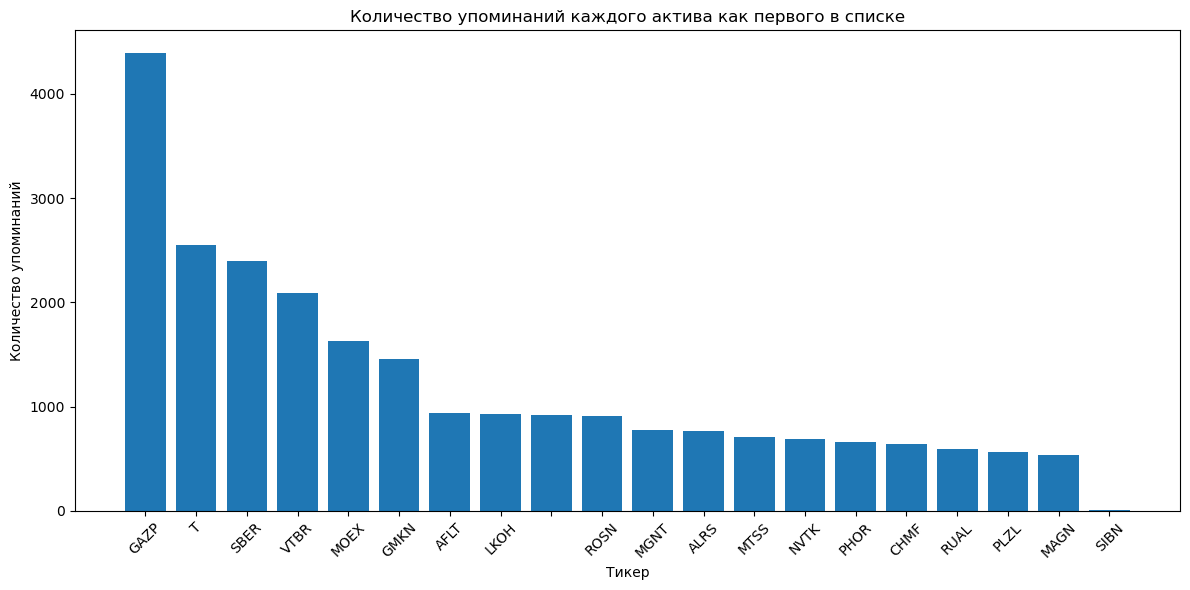

In [190]:
# Получаем первый тикер из строки tickers (до первой запятой)
first_ticker = train_news['tickers'].str.split(',', n=1).str[0]

# Считаем количество статей, где тикер стоит первым
first_ticker_counts = first_ticker.value_counts().reset_index()
first_ticker_counts.columns = ['ticker', 'first_mentions']


plt.figure(figsize=(12, 6))
plt.bar(first_ticker_counts['ticker'], first_ticker_counts['first_mentions'])
plt.xlabel('Тикер')
plt.ylabel('Количество упоминаний')
plt.title('Количество упоминаний каждого актива как первого в списке')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Строим график цены и количества новостей

all_tickers=array(['AFLT', 'RUAL', 'MGNT', 'VTBR', 'ALRS', 'PLZL', 'GAZP', 'SIBN',
       'CHMF', 'LKOH', 'PHOR', 'T', 'ROSN', 'MOEX', 'MTSS', 'NVTK',
       'SBER', 'MAGN', 'GMKN'], dtype=object)


/var/folders/td/cbfq31q93ln9cyfyjyjb5qvh0000gn/T/ipykernel_72296/3628259583.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news['publish_date'] = pd.to_datetime(news['publish_date'])


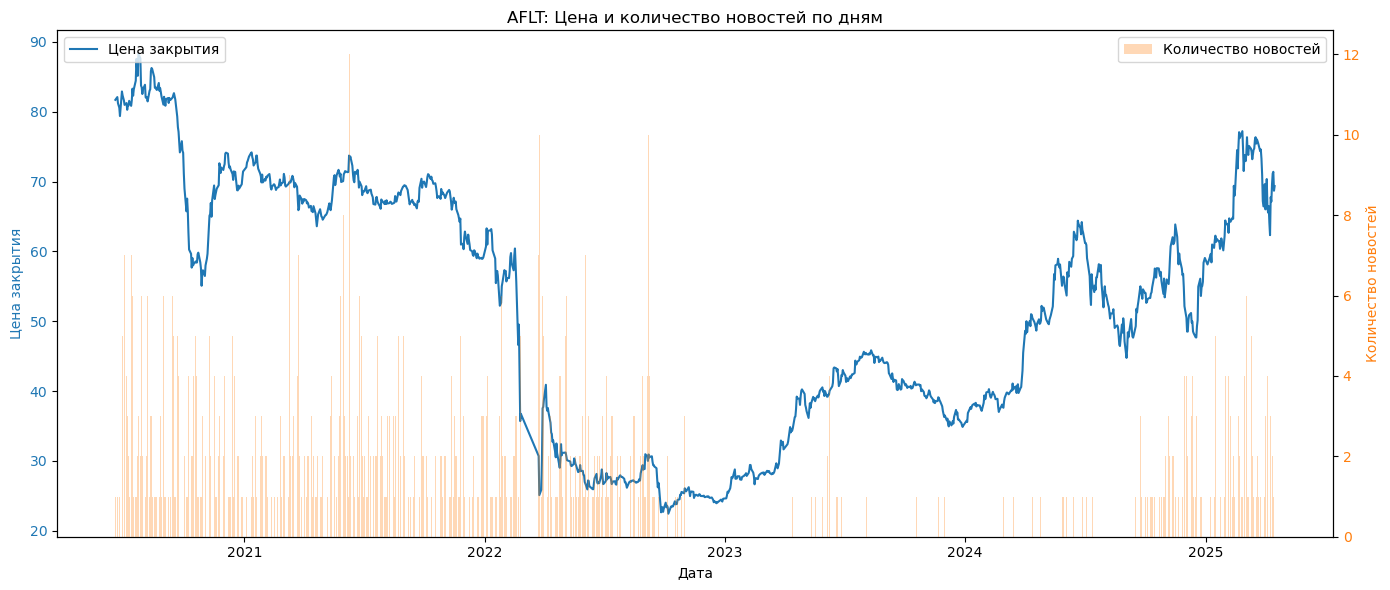

In [191]:
def plot_price_and_news_per_day(ticker, train_candles, train_news):
    # Фильтруем свечи по тикеру и сортируем по дате
    df_candles = train_candles[train_candles['ticker'] == ticker].sort_values('begin')
    if df_candles.empty:
        print(f"Нет данных по тикеру {ticker}")
        return

    # Готовим данные по новостям: фильтруем по тикеру и дате, группируем по дню
    news = train_news[train_news['tickers'].str.contains(ticker)]
    news['publish_date'] = pd.to_datetime(news['publish_date'])
    news_per_day = news.groupby(news['publish_date'].dt.date).size()

    # Готовим ось X (даты) и Y (цена закрытия)
    dates = df_candles['begin']
    prices = df_candles['close']

    # Для новостей: приводим к тому же диапазону дат, что и свечи
    news_counts = news_per_day.reindex(dates.dt.date, fill_value=0)

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Линия цены
    ax1.plot(dates, prices, color='tab:blue', label='Цена закрытия')
    ax1.set_xlabel('Дата')
    ax1.set_ylabel('Цена закрытия', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Бары количества новостей
    ax2 = ax1.twinx()
    ax2.bar(dates, news_counts.values, width=1, color='tab:orange', alpha=0.3, label='Количество новостей')
    ax2.set_ylabel('Количество новостей', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Легенда и оформление
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(f"{ticker}: Цена и количество новостей по дням")
    plt.tight_layout()
    plt.show()

all_tickers = train_candles['ticker'].unique()
print(f'{all_tickers=}')
ticker = all_tickers[0]
plot_price_and_news_per_day(ticker, train_candles, train_news)

#### Считает количество новостей в гэпах

In [192]:
from datetime import timedelta

# Найдем все строки, где diff > 5 (разрыв в данных по датам)
gaps = train_candles[train_candles['diff'].notna() & (train_candles['diff'] > 5)]

# Для каждого разрыва определим диапазон пропущенных дат и посчитаем количество новостей в эти даты

gap_info = []

for idx, row in gaps.iterrows():
    ticker = row['ticker']
    gap_end = row['begin']
    gap_days = int(row['diff']) - 1
    gap_start = gap_end - timedelta(days=gap_days)
    # Пропущенные даты (исключая gap_end, включая gap_start+1)
    missing_dates = [gap_start + timedelta(days=i) for i in range(1, gap_days+1)]
    for missing_date in missing_dates:
        # Считаем количество новостей по тикеру в этот день
        news_count = train_news[
            (train_news['tickers'].str.contains(ticker)) &
            (pd.to_datetime(train_news['publish_date']).dt.date == missing_date.date())
        ].shape[0]
        gap_info.append({
            'ticker': ticker,
            'missing_date': missing_date.date(),
            'news_count': news_count
        })

gap_df = pd.DataFrame(gap_info)
print(gap_df)

    ticker missing_date  news_count
0     RUAL   2020-09-23           4
1     RUAL   2020-09-24           5
2     RUAL   2020-09-25           4
3     RUAL   2020-09-26           0
4     RUAL   2020-09-27           0
..     ...          ...         ...
552   PLZL   2025-03-23           0
553   PLZL   2025-03-24           1
554   PLZL   2025-03-25           4
555   PLZL   2025-03-26           3
556   PLZL   2025-03-27           6

[557 rows x 3 columns]


In [193]:
gap_df['news_count'].sum()

2375